# Importing data

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from IPython.display import display
import plotly.express as px
from datetime import datetime
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

sns.set_style('whitegrid')

In [105]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, 'Datasets')

In [106]:
btc = pd.read_csv(os.path.join(DATA_DIR,'btc.csv'),float_precision='high')
eth = pd.read_csv(os.path.join(DATA_DIR,'eth.csv'),float_precision='high')
ada = pd.read_csv(os.path.join(DATA_DIR,'ada.csv'),float_precision='high')
xrp = pd.read_csv(os.path.join(DATA_DIR,'xrp.csv'),float_precision='high')
bnb = pd.read_csv(os.path.join(DATA_DIR,'bnb.csv'),float_precision='high')

In [107]:
drop_features= ['textBlob_polarity','textBlob_subjectivity',
          'vader_compound','vader_negative_score','vader_positive_score','vader_neutral_score',
          'finbert_text_label','finbert_title_label','textBlob_label','vader_label','lm_label',
          'finBert_title_positive_score','finBert_title_negative_score','finBert_title_neutral_score']
btc.drop(drop_features,axis=1, inplace=True)
eth.drop(drop_features,axis=1, inplace=True)
ada.drop(drop_features,axis=1, inplace=True)
xrp.drop(drop_features,axis=1, inplace=True)
bnb.drop(drop_features,axis=1, inplace=True)

# Identification

In [108]:
btc.date = pd.to_datetime(btc.date, infer_datetime_format=True)
eth.date = pd.to_datetime(eth.date, infer_datetime_format=True)
xrp.date = pd.to_datetime(xrp.date, infer_datetime_format=True)
ada.date = pd.to_datetime(ada.date, infer_datetime_format=True)
bnb.date = pd.to_datetime(bnb.date, infer_datetime_format=True)

In [109]:
btc.set_index('date',inplace=True)
btc.sort_index(inplace=True)

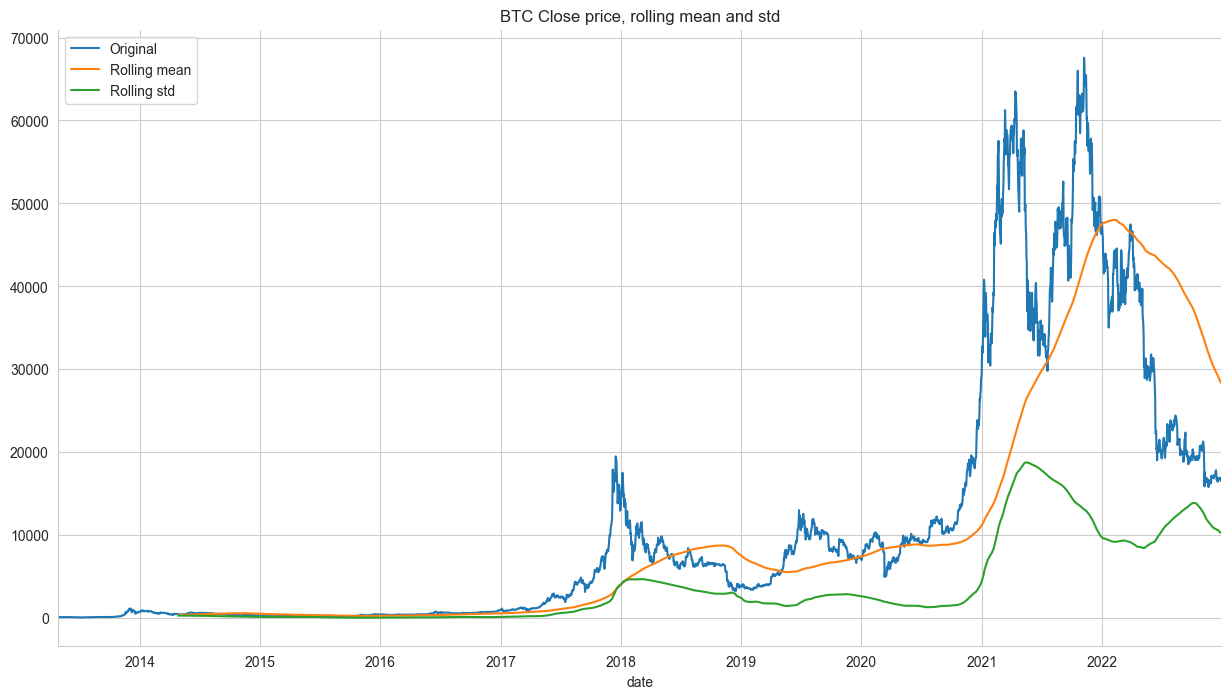

In [110]:
btc.close.plot(figsize = (15, 8))
btc.close.rolling(window=365).mean().plot()
btc.close.rolling(window=365).std().plot()
plt.legend(['Original', 'Rolling mean', 'Rolling std'])
plt.title('BTC Close price, rolling mean and std')
sns.despine()
plt.show()

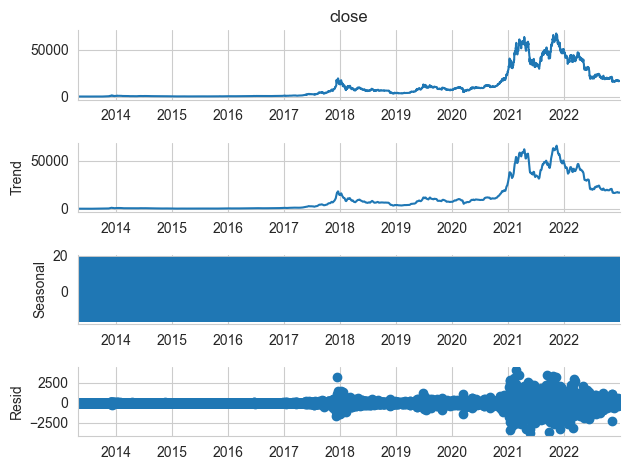

In [111]:
decomp_result = seasonal_decompose(btc.close,extrapolate_trend='freq')
decomp_result.plot()
sns.despine()
plt.show()

- We can observe an upward trend 
- We can't identify any seasonal pattern from the plot
    - The ts is probably to noisy. Hence we will resample the daily data to monthly data
- Result: TS is not stationary

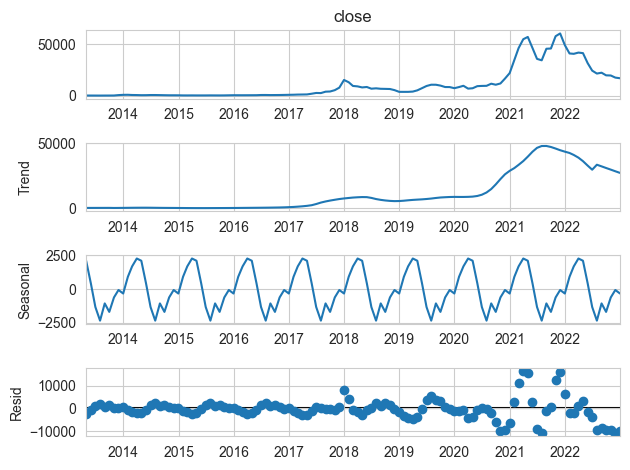

In [112]:
btc_monthly = btc.resample('M').mean()
btc_monthly = btc_monthly.close
decomp_monthly = seasonal_decompose(btc_monthly, extrapolate_trend='freq')
decomp_monthly.plot()
plt.show()

- We can observe an upward trend and a seasonal pattern
- Result TS is not stationary

Stationary Test
- data doesn't change with time (zero trend, not growing/shrinking, variance is constant)

- We will work to model returns
    - https://stats.stackexchange.com/questions/465514/why-prices-are-usually-not-stationary-but-returns-are-more-likely-to-be-station
    - Practical Time Series Analysis Prediction with Statistics & Machine Learning p.409

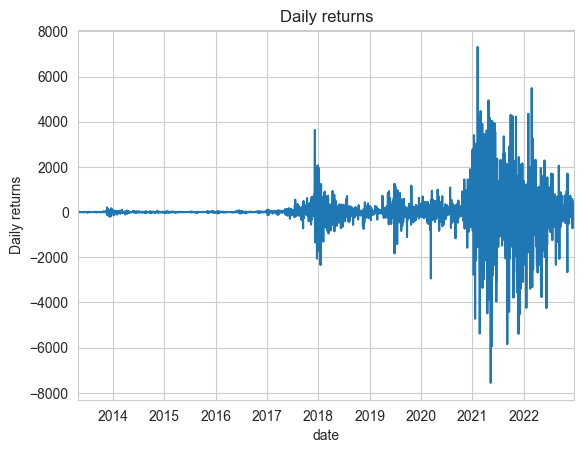

In [113]:
btc['returns'] = btc.close - btc.open
btc.returns.plot()
plt.ylabel('Daily returns')
plt.title('Daily returns')
plt.show()

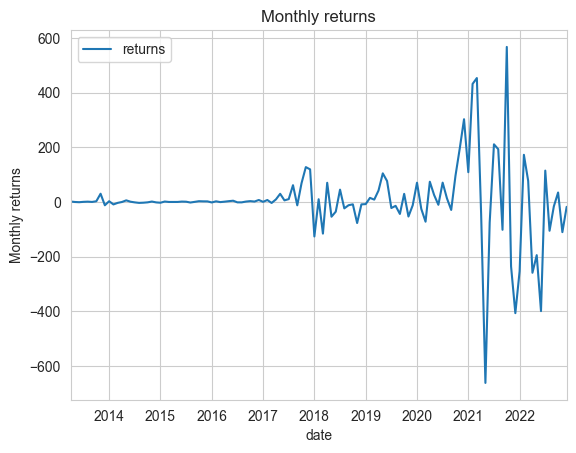

In [114]:
returns = btc['returns'].resample('M').mean().to_frame()
returns.plot()
plt.ylabel('Monthly returns')
plt.title('Monthly returns')
plt.show()

In [115]:
# Dickey Fuller Test
def adfuller_test(data):
# https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

def kpps_test(data):
    result = kpss(data, regression='ct')
    print('\nKPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critial Values:' ,result[3:])
    if result[1] >= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [116]:
adfuller_test(returns)
kpps_test(returns)

ADF Test Statistic : -2.650756638568591
p-value : 0.08295395254337501
#Lags Used : 6
Number of Observations Used : 110
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

KPSS Statistic: 0.072969
p-value: 0.100000
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [117]:
adfuller_test(btc.returns)
kpps_test(btc.returns)

ADF Test Statistic : -9.055102749846851
p-value : 4.7247930419533445e-15
#Lags Used : 30
Number of Observations Used : 3502
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

KPSS Statistic: 0.086229
p-value: 0.100000
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In order to make the monthly data stationary we will differencing the data

Transformation

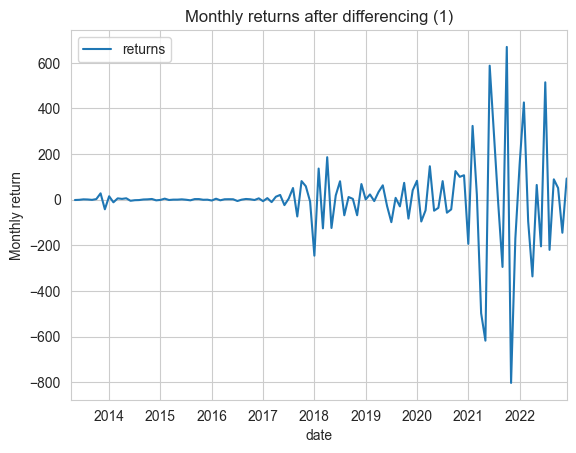

In [118]:
returns.diff().plot()
plt.ylabel('Monthly return')
plt.title('Monthly returns after differencing (1)')
plt.show()

In [119]:
adfuller_test(returns.diff().dropna())
kpps_test(returns.diff().dropna())

ADF Test Statistic : -10.096696074997945
p-value : 1.0861204943484356e-17
#Lags Used : 5
Number of Observations Used : 110
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

KPSS Statistic: 0.500000
p-value: 0.010000
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [120]:
adfuller_test(returns.diff(2).dropna())
kpps_test(returns.diff(2).dropna())

ADF Test Statistic : -3.2483850247060007
p-value : 0.017349323606868146
#Lags Used : 13
Number of Observations Used : 101
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

KPSS Statistic: 0.212485
p-value: 0.011318
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [121]:
adfuller_test(returns.diff(3).dropna())
kpps_test(returns.diff(3).dropna())

ADF Test Statistic : -3.5003040144257667
p-value : 0.007979289758974816
#Lags Used : 13
Number of Observations Used : 100
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

KPSS Statistic: 0.011477
p-value: 0.100000
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [122]:
returns = returns.diff(3).dropna()

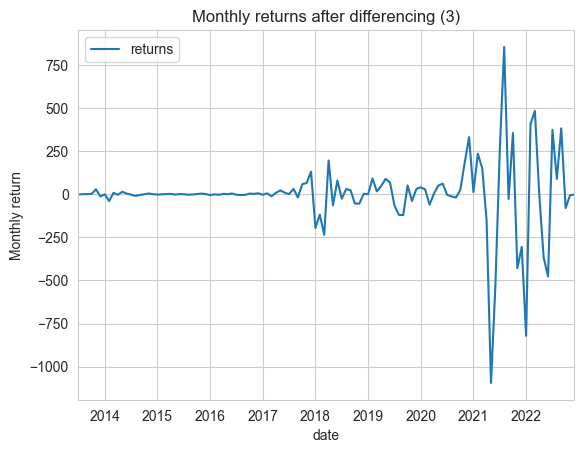

In [123]:
returns.plot()
plt.ylabel('Monthly return')
plt.title('Monthly returns after differencing (3)')
plt.show()

Autocorrelation 
- Correlation between ts and same ts offset by x step(lag)

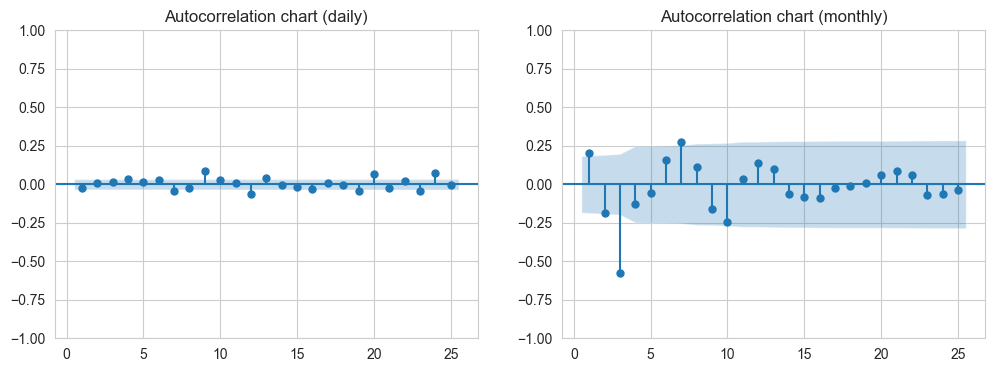

In [124]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(btc.returns,lags=25, zero=False,title="Autocorrelation chart (daily)",ax=ax[0])
plot_acf(returns,lags=25, zero=False,title="Autocorrelation chart (monthly)",ax=ax[1])
plt.show()

- We can observe that the acf lag 4 is statistically significant for daily data and the acf lag 1/3 are significant for monthly data (MA part)

Partial Autocorrelation
- Correlation between ts and the lagged version of itself after subtract the effect of correlation at smaller lags
- Correaltion with just that particula lag

C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



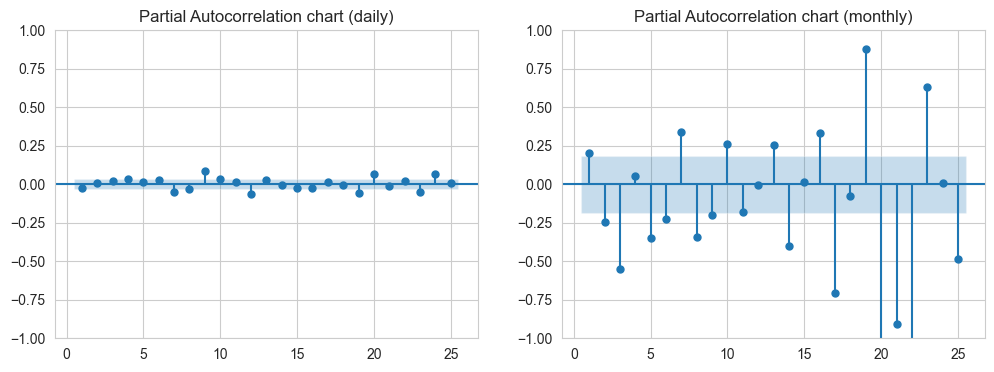

In [125]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_pacf(btc.returns,lags=25, zero=False,title="Partial Autocorrelation chart (daily)",ax=ax[0])
plot_pacf(returns,lags=25, zero=False,title="Partial Autocorrelation chart (monthly)",ax=ax[1])
plt.show()

- We can observe that the acf lag 4 is statistically significant for daily data and the acf lag 1/19 are significant for monthly data (MA part)

Result: The ACF and the PACF tails off --> We can't deduce the model order of p and q from the plots

# Pmdarima

- We will use pmdarima  with a machine learning approach to build the models
- Reference: 
    - https://alkaline-ml.com/pmdarima/usecases/stocks.html
    - https://datascience.stackexchange.com/questions/53144/do-we-have-to-split-our-dataset-into-training-testing-when-using-arima-model

## Daily Model

In [127]:
split = int(len(btc)*0.8)
train_daily, test_daily = btc.iloc[:split].returns, btc.iloc[split:].returns
print(train_daily.shape, test_daily.shape)

(2826,) (707,)


In [128]:
model_daily = pm.auto_arima(train_daily,
                        d=1,
                        start_p=0,
                        start_q=0,
                        max_p=10,
                        max_q=10,
                        seasonal=False,
                        information_criterion='aic',
                        trace = True,
                        error_action='ignore',
                        stepwise = True,
                        max_order=None,
                        random_state=42)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42202.085, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41709.587, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42200.129, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41441.474, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41263.596, Time=0.26 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=41031.708, Time=0.38 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=40963.951, Time=0.44 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=40913.421, Time=0.61 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=40889.713, Time=0.67 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=40866.112, Time=0.90 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=40775.280, Time=1.02 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=40725.512, Time=1.49 sec
 ARIMA(10,1,1)(0,0,0)[0] intercept   : AIC=40715.765, Time=6.07 sec
 ARIMA(9,1,1)(0,0,0)[0]

In [129]:
model_daily.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2826
Model:              SARIMAX(10, 1, 1)   Log Likelihood              -20344.929
Date:                Sun, 29 Jan 2023   AIC                          40713.858
Time:                        18:05:06   BIC                          40785.213
Sample:                    04-28-2013   HQIC                         40739.603
                         - 01-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4737      0.041    -11.679      0.000      -0.553      -0.394
ar.L2         -0.5424      0.033    -16.224      0.000      -0.608      -0.477
ar.L3         -0.5193      0.033    -15.902      0.000      -0.583      -0.455
ar.L4         -0.4911      0.032    -15.154      0.000      -0.555      -0.428
ar.L5         -0.3518      0.030    -11.660      0.000      -0.411      -0.293
ar.L6         -0.3371      0.025    -13.745      0.000      -0.385      -0.289
ar.L7         -0.2801      0.021    -13.386      0.000      -0.321      -0.239
ar.L8         -0.2556      0.016    -16.245      0.000      -0.286      -0.225
ar.L9         -0.2309      0.013    -17.348      0.000      -0.257      -0.205
ar.L10        -0.0856      0.013     -6.655      0.000      -0.111      -0.060
ma.L1         -0.3524      0.041     -8.505      0.000      -0.434      -0.271
sigma2      1.062e+05    802.782    132.278      0.000    1.05e+05    1.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            120216.20
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             304.62   Skew:                            -1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In-sample prediction

In [130]:
#https://alkaline-ml.com/pmdarima/usecases/stocks.html
def forecast_one_step(pm_model, n_periods=1):
    model = pm_model
    fc, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    return (fc.tolist()[0],np.asarray(conf_int).tolist()[0])

def forecast_test(pm_model,test):
    forecasts = []
    confidence_intervals = []
    model = pm_model
    
    for new_ob in test:
        fc, conf = forecast_one_step(model)
        forecasts.append(fc)
        confidence_intervals.append(conf)
        # Updates the existing model with a small number of MLE steps
        model.update(new_ob)
    print(f"Mean squared error: {mean_squared_error(test, forecasts)}")
    return forecasts, confidence_intervals

In [131]:
forecasts, confidence_intervals = forecast_test(model_daily,test_daily)

Mean squared error: 2591140.2987513477


In [132]:
f_data = pd.DataFrame({'dates':test_daily.index, 'forecast':forecasts})
f_data.set_index('dates',inplace=True)

In [133]:
evalute_daily = f_data.join(test_daily)
evalute_daily.sample(10)

,forecast,returns
dates,,
2022-09-21,-169.198967,-343.883130
2021-10-02,900.878560,-425.982269
2022-03-13,-609.661617,-1035.062049
2021-06-20,95.629021,135.157028
2022-03-18,721.742320,856.312817
2021-08-09,1017.829963,2573.473227
2021-03-29,303.800856,1802.300905
2021-04-17,-442.907553,-846.099764
2022-08-12,1.064987,445.615445


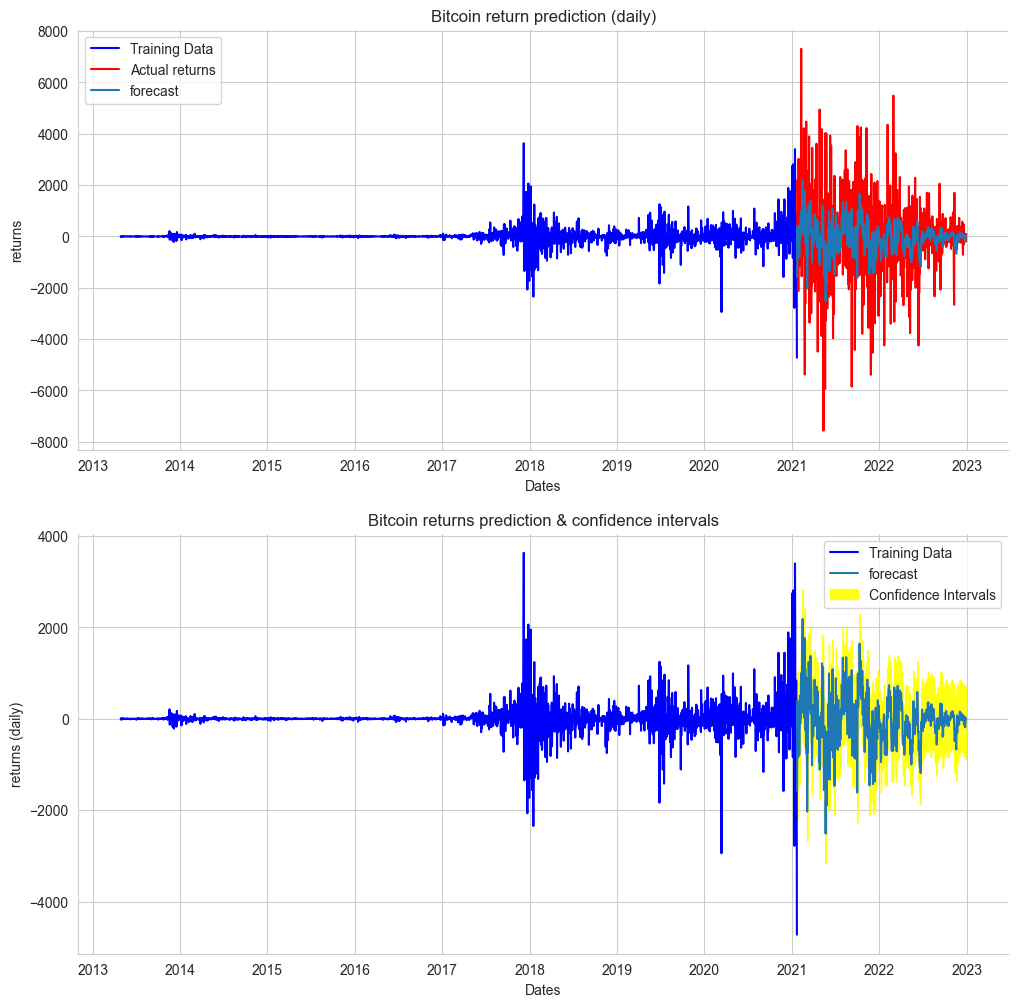

In [134]:
#https://alkaline-ml.com/pmdarima/usecases/stocks.html
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.lineplot(train_daily, color='blue', label='Training Data', ax=axes[0])
sns.lineplot(test_daily, color='red', label='Actual returns', ax=axes[0])
sns.lineplot(f_data,color='green',ax=axes[0])


axes[0].set_title('Bitcoin return prediction (daily)')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('returns')
axes[0].legend()

sns.lineplot(train_daily, color='blue', label='Training Data', ax=axes[1])
sns.lineplot(f_data,color='green', ax=axes[1])
axes[1].set_title('Bitcoin returns prediction & confidence intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('returns (daily)')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_daily.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='yellow',
                     label="Confidence Intervals")

axes[1].legend()
sns.despine()
plt.show()

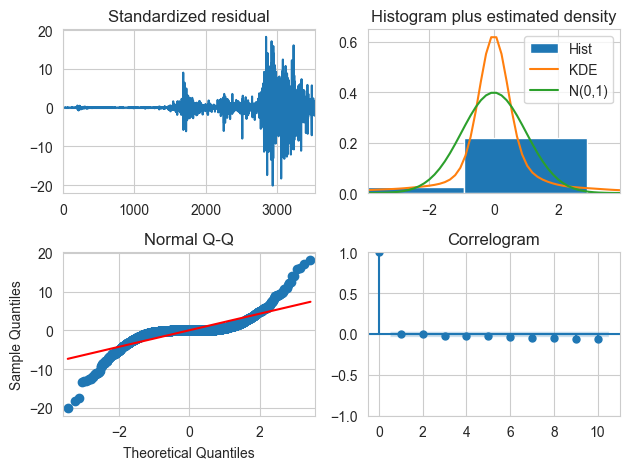

In [135]:
model_daily.plot_diagnostics()
plt.tight_layout()
plt.show()

Out-of sample prediction

In [136]:
date = [datetime(2022,12,30),datetime(2022,12,31), datetime(2023,1,1),datetime(2023,1,2),datetime(2023,1,3),
        datetime(2023,1,4),datetime(2023,1,5),datetime(2023,1,6),datetime(2023,1,7)]
df = pd.DataFrame({'date':date})

In [137]:
predictions =[]
ci_intervals=[]
for i in range(1,10):
    prediction, confidence_intervals= forecast_one_step(model_daily, n_periods=i)
    model_daily.update(prediction)
    predictions.append(prediction)
    #print(df.iloc[i-1])
    ci_intervals.append(confidence_intervals)

In [138]:
df['predictions'] = predictions
#df.set_index('date',inplace=True)
all = pd.concat([train_daily.to_frame(),test_daily.to_frame(),df.set_index('date')])

In [139]:
fig = px.line(all.iloc[-100:],title='BTC Close: 4 months forecast').update_layout(xaxis_title='Date',yaxis_title='Close')
fig.show()

## Monthly model

In [140]:
split = int(len(btc_monthly)*0.8)
train_monthly, test_monthly = returns.iloc[:split].squeeze(), returns.iloc[split:].squeeze()
print(train_monthly.shape, test_monthly.shape)

(93,) (21,)


In [141]:
model_monthly= pm.auto_arima(train_monthly,
                        d=1,
                        start_p=0,
                        start_q=0,
                        max_p=10,
                        max_q=10,
                        seasonal=True,
                        information_criterion='aic',
                        trace = True,
                        error_action='ignore',
                        stepwise = True,
                        m=12,
                        D=None,
                        start_P=1,
                        start_Q=1,
                        max_P=10,
                        max_Q=10
                       )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1095.267, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1094.177, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1064.498, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1053.333, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1092.208, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1051.424, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1053.320, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1053.060, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1053.200, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1062.515, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1050.219, Time=0.19 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=1051.893, Time=0.55 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1051.890, Time=0.48 sec
 ARIMA(1,1,2)(1,0,1)[12]

In [142]:
model_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -517.527
Date:                Sun, 29 Jan 2023   AIC                           1045.054
Time:                        18:16:04   BIC                           1057.663
Sample:                    07-31-2013   HQIC                          1050.143
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0083      0.131     -0.063      0.950      -0.266       0.249
ar.L2          0.1016      0.110      0.927      0.354      -0.113       0.316
ar.L3         -0.3532      0.079     -4.458      0.000      -0.509      -0.198
ma.L1         -0.7097      0.142     -4.981      0.000      -0.989      -0.430
sigma2      4441.6705    389.826     11.394      0.000    3677.626    5205.715
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                77.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              98.21   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

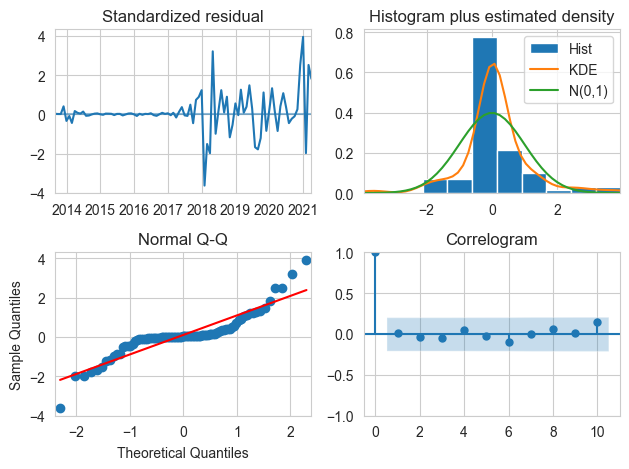

In [143]:
model_monthly.plot_diagnostics()
plt.tight_layout()
plt.show()

In-sample prediction

In [144]:
forecasts, confidence_intervals = forecast_test(model_monthly,test_monthly)

Mean squared error: 193461.67906710753


In [145]:
f_data = pd.DataFrame({'dates':test_monthly.index, 'forecast':forecasts})
f_data.set_index('dates',inplace=True)

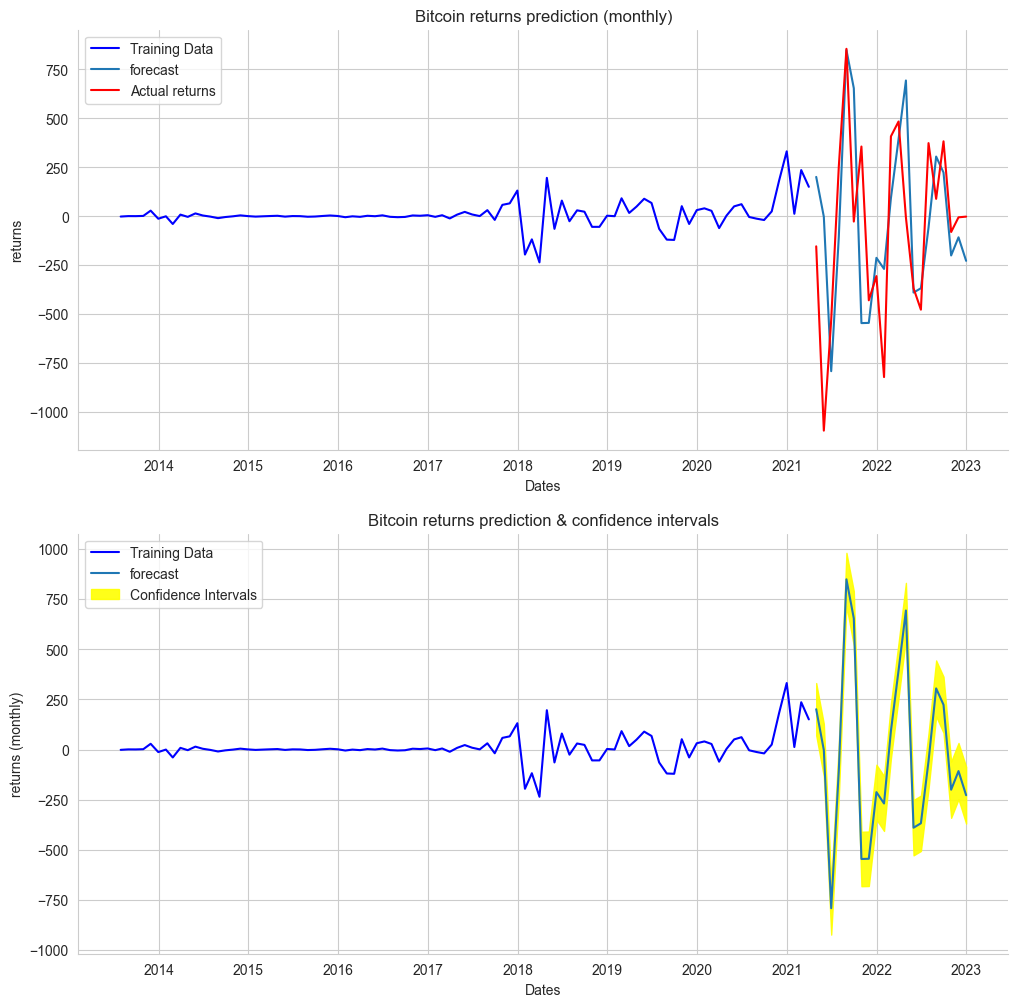

In [146]:
##https://alkaline-ml.com/pmdarima/usecases/stocks.html
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.lineplot(train_monthly, color='blue', label='Training Data', ax=axes[0])
sns.lineplot(f_data,color='green', ax=axes[0])
sns.lineplot(test_monthly, color='red', label='Actual returns', ax=axes[0])

axes[0].set_title('Bitcoin returns prediction (monthly)')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('returns')
axes[0].legend()

sns.lineplot(train_monthly, color='blue', label='Training Data', ax=axes[1])
sns.lineplot(f_data,color='green', ax=axes[1])
axes[1].set_title('Bitcoin returns prediction & confidence intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('returns (monthly)')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_monthly.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='yellow',
                     label="Confidence Intervals")

axes[1].legend()
sns.despine()
plt.show()

Out-of-sample prediction

In [147]:
date = [datetime(2023,1,31),datetime(2023,2,28),datetime(2023,3,31),datetime(2023,4,30)]
df=pd.DataFrame({'date':date})

In [148]:
predictions =[]
ci_intervals=[]
for i in range(1,5):
    prediction, confidence_intervals= forecast_one_step(model_monthly, n_periods=i)
    model_monthly.update(prediction)
    predictions.append(prediction)
    #print(df.iloc[i-1])
    ci_intervals.append(confidence_intervals)

In [149]:
df['predictions'] = predictions
#df.set_index('date',inplace=True)
all = pd.concat([train_monthly.to_frame(),test_monthly.to_frame(),df.set_index('date')])

In [150]:
fig = px.line(all,title='BTC returns: 4 months forecast').update_layout(xaxis_title='Date',yaxis_title='Close')
fig.show()